## Q1. Notebook
We'll start with the same notebook we ended up with in homework 1. We cleaned it a little bit and kept only the scoring part. You can find the initial notebook here.

Run this notebook for the March 2023 data.

What's the standard deviation of the predicted duration for this dataset?

- 1.24
- 6.24
- 12.28
- 18.28

Answer: 6.24

In [1]:
!pip freeze | grep scikit-learn

scikit-learn @ file:///tmp/build/80754af9/scikit-learn_1642617106979/work
scikit-learn-intelex==2021.20220215.212715


In [2]:
!python -V

Python 3.9.12


In [3]:
import pickle
import pandas as pd

In [4]:
with open('model.bin', 'rb') as f_in:
    dv, model = pickle.load(f_in)

/home/codespace/anaconda3/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DictVectorizer from version 1.5.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/codespace/anaconda3/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LinearRegression from version 1.5.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [5]:
categorical = ['PULocationID', 'DOLocationID']

def read_data(filename):
    df = pd.read_parquet(filename)
    
    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df['duration'] = df.duration.dt.total_seconds() / 60

    df = df[(df.duration >= 1) & (df.duration <= 60)].copy()

    df[categorical] = df[categorical].fillna(-1).astype('int').astype('str')
    
    return df

In [6]:
df = read_data('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-03.parquet')

In [7]:
dicts = df[categorical].to_dict(orient='records')
X_val = dv.transform(dicts)
y_pred = model.predict(X_val)

In [8]:
y_pred.std()

6.247488852238703

## Q2. Preparing the output
Like in the course videos, we want to prepare the dataframe with the output.

First, let's create an artificial `ride_id` column:

``` python
df['ride_id'] = f'{year:04d}/{month:02d}_' + df.index.astype('str')
```

Next, write the ride id and the predictions to a dataframe with results.

Save it as parquet:

```python
df_result.to_parquet(
    output_file,
    engine='pyarrow',
    compression=None,
    index=False
)
```
What's the size of the output file?

- 36M
- 46M
- 56M
- 66M
Note: Make sure you use the snippet above for saving the file. It should contain only these two columns. For this question, don't change the dtypes of the columns and use `pyarrow`, not `fastparquet`.

Answer: 66M

In [12]:
df['ride_id'] = '2023/03_' + df.index.astype('str')

df_result = df[['ride_id']].copy()
df_result['pred_duration'] = y_pred

df_result

,ride_id,pred_duration
0,2023/03_0,16.245906
1,2023/03_1,26.134796
2,2023/03_2,11.884264
3,2023/03_3,11.997720
4,2023/03_4,10.234486
...,...,...
3403761,2023/03_3403761,11.952635
3403762,2023/03_3403762,20.049958
3403763,2023/03_3403763,11.595336
3403764,2023/03_3403764,13.113178


In [15]:
df_result.to_parquet(
    "output.parquet",
    engine='pyarrow',
    compression=None,
    index=False
)

In [16]:
!du -h output.parquet 

66M	output.parquet


## Q3. Creating the scoring script
Now let's turn the notebook into a script.

Which command you need to execute for that?

In [1]:
!jupyter nbconvert --to script homework.ipynb

[NbConvertApp] Converting notebook homework.ipynb to script
[NbConvertApp] Writing 2462 bytes to homework.py


## Q4. Virtual environment
Now let's put everything into a virtual environment. We'll use pipenv for that.

Install all the required libraries. Pay attention to the Scikit-Learn version: it should be the same as in the starter notebook.

After installing the libraries, pipenv creates two files: `Pipfile` and `Pipfile.lock`. The `Pipfile.lock` file keeps the hashes of the dependencies we use for the virtual env.

What's the first hash for the Scikit-Learn dependency?

Answer: sha256:08ef968f6b72033c16c479c966bf37ccd49b06ea91b765e1cc27afefe723920b

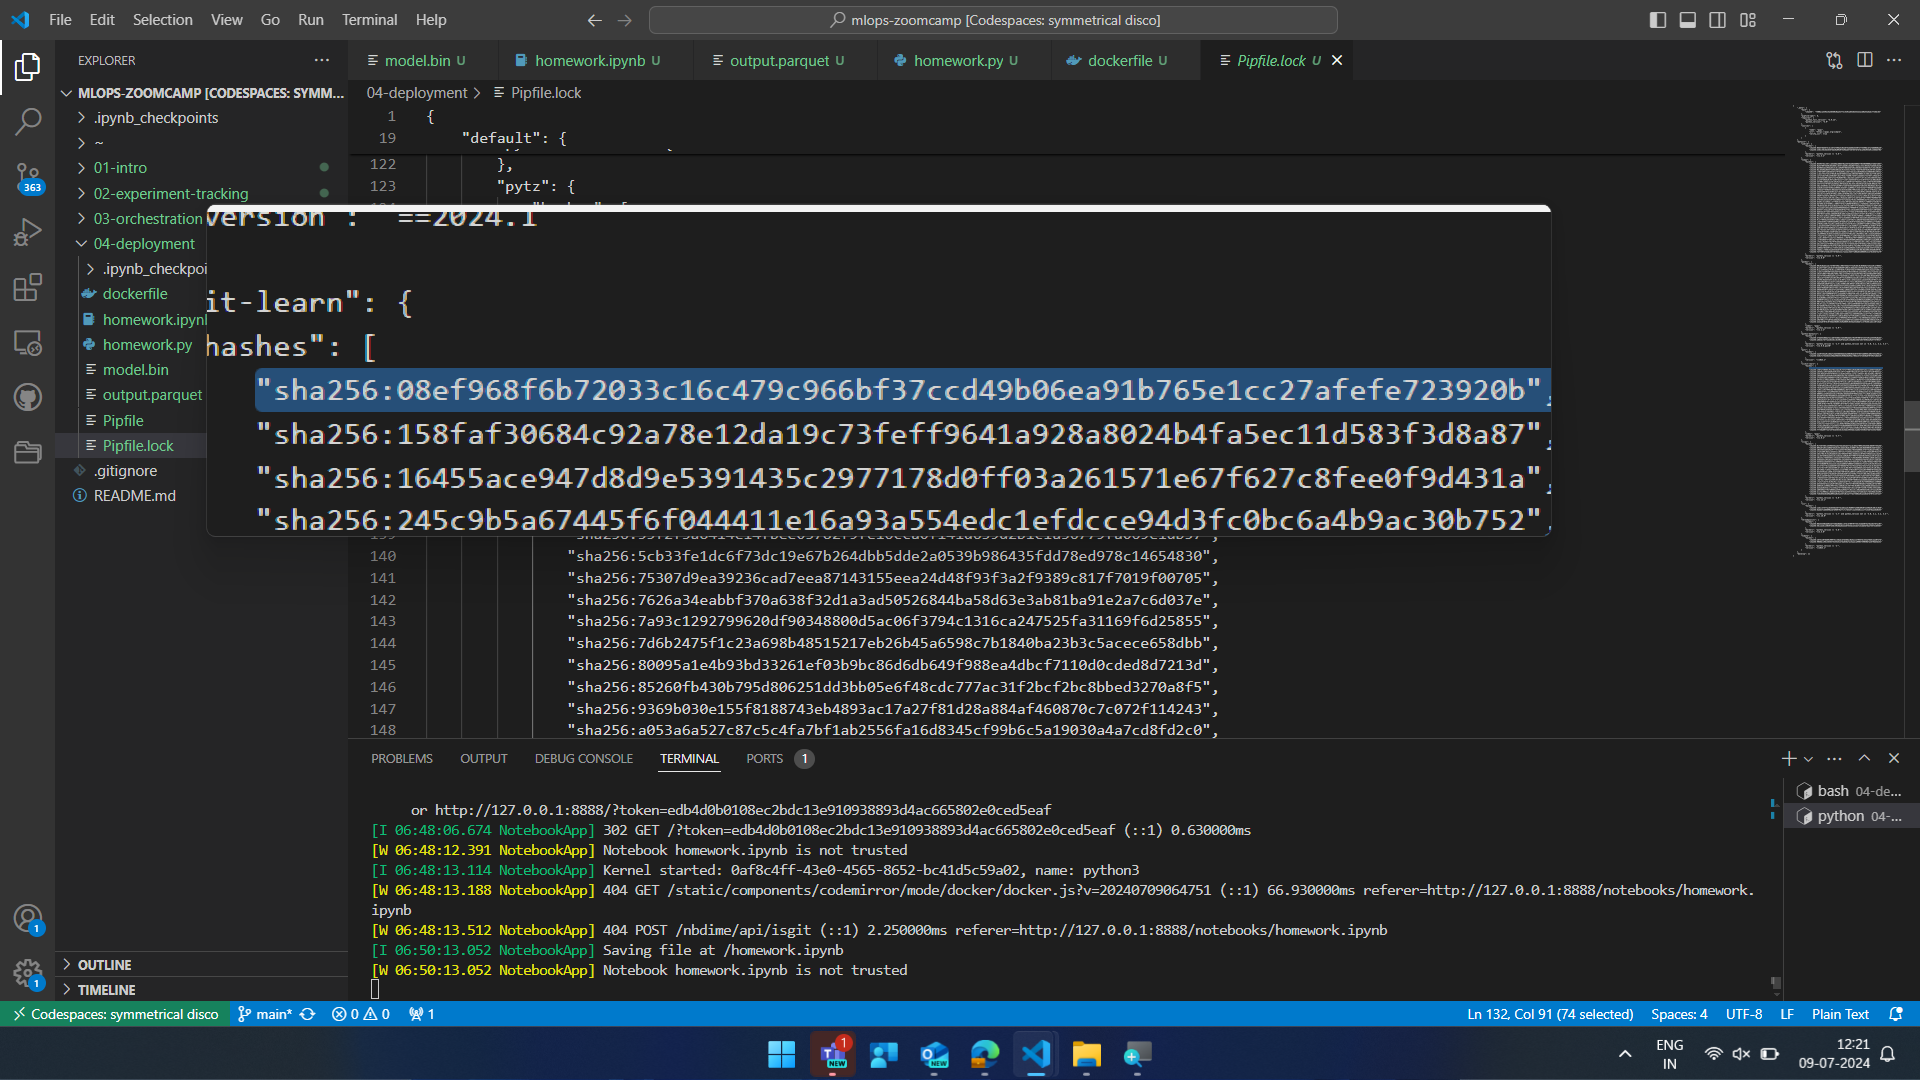

## Q5. Parametrize the script
Let's now make the script configurable via CLI. We'll create two parameters: year and month.

Run the script for April 2023.

What's the mean predicted duration?

- 7.29
- 14.29
- 21.29
- 28.29

Hint: just add a print statement to your script.

Answer: 14.29

In [2]:
! python homework.py 2023 04

/home/codespace/anaconda3/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DictVectorizer from version 1.5.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/codespace/anaconda3/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LinearRegression from version 1.5.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
14.292282936862449


## Q6. Docker container
Finally, we'll package the script in the docker container. For that, you'll need to use a base image that we prepared.

This is what the content of this image is:

``` docker
FROM python:3.10.13-slim

WORKDIR /app
COPY [ "model2.bin", "model.bin" ]
```
Note: you don't need to run it. We have already done it.

It is pushed to `agrigorev/zoomcamp-model:mlops-2024-3.10.13-slim`, which you need to use as your base image.

That is, your Dockerfile should start with:

``` docker
FROM agrigorev/zoomcamp-model:mlops-2024-3.10.13-slim

# do stuff here
```

This image already has a pickle file with a dictionary vectorizer and a model. You will need to use them.

Important: don't copy the model to the docker image. You will need to use the pickle file already in the image.

Now run the script with docker. What's the mean predicted duration for May 2023?

- 0.19
- 7.24
- 14.24
- 21.19

Answer: 0.19

In [1]:
! docker run homework 2023 05

/usr/local/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DictVectorizer from version 1.5.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LinearRegression from version 1.5.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
1.21.5
0.19174419265916945
